# 02 - Analysis & Visualizations

**SC/MATH 1130 A - Introduction to Data Science**

**Project**: The Impact of AI on Canadian Wages

---

## Analysis Sections

- **Section 2.1**: Historical Wage Growth (2012-2024)
- **Section 2.2**: Entry-Level Job Market Impact
- **Section 2.3**: Occupational Vulnerability Assessment

---


## Setup & Imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Setup paths
BASE_DIR = Path("..")
MERGED_DATA = BASE_DIR / "data" / "merged"
OUTPUTS_FIGURES = BASE_DIR / "outputs" / "figures"
OUTPUTS_TABLES = BASE_DIR / "outputs" / "tables"

# Create output directories
OUTPUTS_FIGURES.mkdir(parents=True, exist_ok=True)
OUTPUTS_TABLES.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"Output figures: {OUTPUTS_FIGURES}")
print(f"Output tables: {OUTPUTS_TABLES}")

✅ Setup complete!
Output figures: ..\outputs\figures
Output tables: ..\outputs\tables


## Load Master Dataset


In [ ]:
# Load merged dataset from cleaning notebook
df = pd.read_csv(MERGED_DATA / "master_dataset.csv")

print(f"Dataset shape: {df.shape}")
print(f"Years: {df['Reference_Period'].min()} - {df['Reference_Period'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (613008, 17)
Years: 2006.0 - 2024.0

Columns: ['NOC_CNP', 'NOC_Title_Standardized', 'Province', 'Region', 'Reference_Period', 'Annual_Wage_Flag_Salaire_annuel', 'Low_Wage_Hourly', 'Median_Wage_Hourly', 'High_Wage_Hourly', 'Average_Wage_Hourly', 'Quartile1_Wage_Hourly', 'Quartile3_Wage_Hourly', 'missing_wage_flag', 'is_entry_level', 'Industry', 'AI_Exposure_Score', 'AI_Exposure_Category']


,NOC_CNP,NOC_Title_Standardized,Province,Region,Reference_Period,Annual_Wage_Flag_Salaire_annuel,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,missing_wage_flag,is_entry_level,Industry,AI_Exposure_Score,AI_Exposure_Category
0,NaN,NaN,NaN,NaN,NaN,0.0,8.17,28.00,49.45,NaN,NaN,NaN,0,0,Other,0.0,NaN
1,NaN,NaN,NaN,NaN,NaN,0.0,17.95,40.06,64.97,NaN,NaN,NaN,0,0,Other,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,19.23,45.67,66.67,NaN,NaN,NaN,0,0,Other,0.0,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Other,0.0,NaN
4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Other,0.0,NaN


In [ ]:
# Quick data quality check
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

Missing values per column:
NOC_CNP                            527008
NOC_Title_Standardized             524256
Province                           480396
Region                             479880
Reference_Period                   576120
Annual_Wage_Flag_Salaire_annuel    129000
Low_Wage_Hourly                    385834
Median_Wage_Hourly                 383394
High_Wage_Hourly                   385814
Average_Wage_Hourly                542612
Quartile1_Wage_Hourly              580638
Quartile3_Wage_Hourly              580634
missing_wage_flag                       0
is_entry_level                          0
Industry                                0
AI_Exposure_Score                       0
AI_Exposure_Category               585832
dtype: int64

Data types:
NOC_CNP                             object
NOC_Title_Standardized              object
Province                            object
Region                              object
Reference_Period                   float64
Annual_Wage_Flag_S

---
# Section 2.1: Historical Wage Growth Analysis

## Research Question:
Have AI-adopting industries experienced different wage growth patterns (2012-2024) compared to low-AI sectors, and does this create widening income inequality?

## Tasks:
1. Calculate wage growth rates by industry and year
2. Compare AI-adopting vs non-AI industries
3. Visualize trends over time
4. Compute inequality metrics (wage spread, Gini coefficient, etc.)
5. Generate summary statistics

---


In [ ]:
# Define pre-AI and post-AI periods
PRE_AI_YEARS = range(2012, 2020)  # Before COVID & LLMs
POST_AI_YEARS = range(2020, 2025)  # After COVID & LLMs

df["Period"] = df["Reference_Period"].apply(
    lambda x: "Pre-AI (2012-2019)" if x in PRE_AI_YEARS else "Post-AI (2020-2024)"
)

print("Period distribution:")
print(df["Period"].value_counts())

Period distribution:
Period
Post-AI (2020-2024)    608120
Pre-AI (2012-2019)       4888
Name: count, dtype: int64


In [ ]:
wage_cols = [
    'Low_Wage_Hourly', 'Median_Wage_Hourly', 'High_Wage_Hourly',
    'Average_Wage_Hourly', 'Quartile1_Wage_Hourly',
    'Quartile3_Wage_Hourly'
]

df_yearly = (
    df.groupby(['Industry', 'Reference_Period'])[wage_cols]
      .mean()
      .reset_index()
)

df_yearly = df_yearly.sort_values(['Industry', 'Reference_Period'])

for col in wage_cols:
    df_yearly[col + '_pct_change'] = (
        df_yearly.groupby('Industry')[col].pct_change()
    )

df_yearly[[c for c in df_yearly.columns if 'pct_change' in c]] *= 100

df_yearly.head()

,Industry,Reference_Period,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,Low_Wage_Hourly_pct_change,Median_Wage_Hourly_pct_change,High_Wage_Hourly_pct_change,Average_Wage_Hourly_pct_change,Quartile1_Wage_Hourly_pct_change,Quartile3_Wage_Hourly_pct_change
0,Accommodation and food services,2023.0,16.435455,19.306364,32.054545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Accommodation and food services,2024.0,17.029014,19.458493,28.507361,NaN,NaN,NaN,3.611458,0.787976,-11.066088,NaN,NaN,NaN
2,Construction,2021.0,18.356364,38.129231,52.407273,39.291538,28.707222,47.108824,NaN,NaN,NaN,NaN,NaN,NaN
3,Construction,2023.0,25.855690,36.578276,50.335690,NaN,NaN,NaN,40.854094,-4.067627,-3.952854,0.0,0.0,0.0
4,Construction,2024.0,26.774712,38.069319,51.971780,NaN,NaN,NaN,3.554430,4.076309,3.250359,0.0,0.0,0.0


In [ ]:
df_yearly.shape

(41, 14)

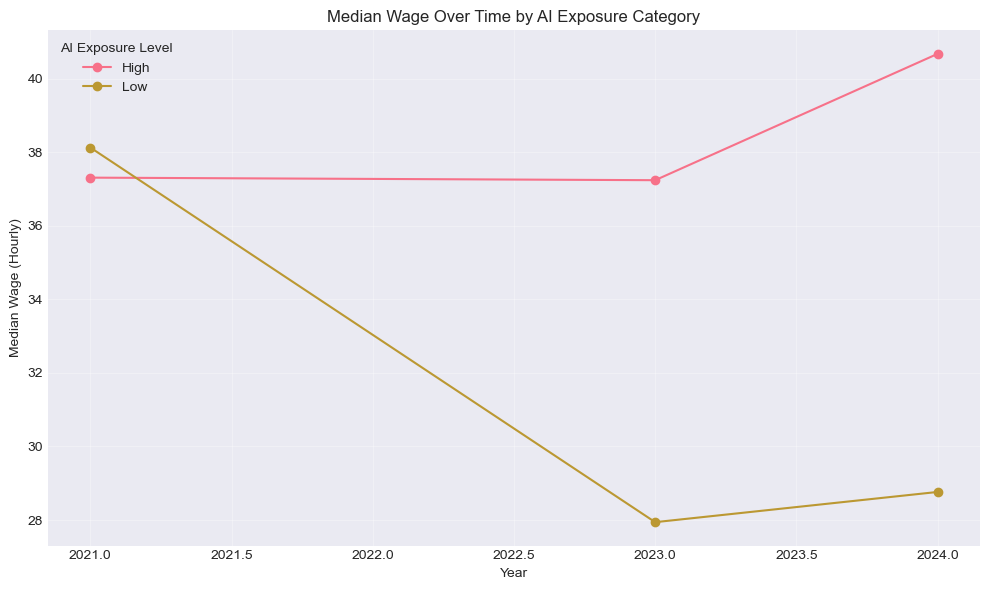

In [ ]:
# Compare high-AI industries vs low-AI industries
# Extract unique industry–exposure mapping
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into yearly wage table
df_wage_exposure = df_yearly.merge(industry_exposure, on='Industry', how='left')

median_by_exposure = (
    df_wage_exposure
    .groupby(['AI_Exposure_Category', 'Reference_Period'])['Median_Wage_Hourly']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))

for category in median_by_exposure['AI_Exposure_Category'].unique():
    subset = median_by_exposure[median_by_exposure['AI_Exposure_Category'] == category]
    plt.plot(
        subset['Reference_Period'],
        subset['Median_Wage_Hourly'],
        marker='o',
        label=category
    )

plt.title("Median Wage Over Time by AI Exposure Category")
plt.xlabel("Year")
plt.ylabel("Median Wage (Hourly)")
plt.legend(title="AI Exposure Level")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic1_wage_trends.png", dpi=300)
plt.show()


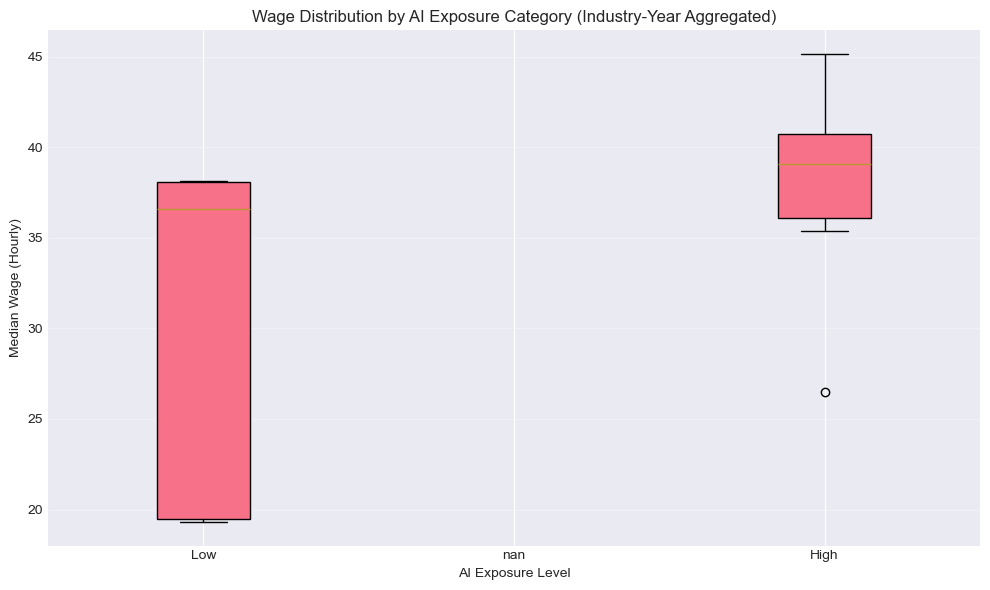

In [ ]:
# Show inequality within and between industries

# Get unique mapping of Industry → AI Exposure Category
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into yearly wage data
df_yearly_box = df_yearly.merge(industry_exposure, on="Industry", how="left")

plt.figure(figsize=(10, 6))

categories = df_yearly_box["AI_Exposure_Category"].unique()

data = [
    df_yearly_box[df_yearly_box["AI_Exposure_Category"] == cat]["Median_Wage_Hourly"]
    for cat in categories
]

plt.boxplot(data, labels=categories, patch_artist=True)

plt.title("Wage Distribution by AI Exposure Category (Industry-Year Aggregated)")
plt.ylabel("Median Wage (Hourly)")
plt.xlabel("AI Exposure Level")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic1_wage_distribution.png", dpi=300)
plt.show()


In [ ]:
# Mean wage growth, median, std dev by industry category
# Get mapping from Industry -> AI Exposure Category
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into df_yearly
df_yearly_stats = df_yearly.merge(industry_exposure, on="Industry", how="left")

growth_cols = [c for c in df_yearly_stats.columns if c.endswith("_pct_change")]
growth_cols

summary_stats = (
    df_yearly_stats
    .groupby("AI_Exposure_Category")[growth_cols]
    .agg(["mean", "median", "std"])
    .reset_index()
)

summary_stats.columns = [
    "_".join(col).strip("_") for col in summary_stats.columns.values
]

summary_stats.to_csv(OUTPUTS_TABLES / 'subtopic1_summary_stats.csv', index=False)
print("Saved: subtopic1_summary_stats.csv")

summary_stats

Saved: subtopic1_summary_stats.csv


,AI_Exposure_Category,Low_Wage_Hourly_pct_change_mean,Low_Wage_Hourly_pct_change_median,Low_Wage_Hourly_pct_change_std,Median_Wage_Hourly_pct_change_mean,Median_Wage_Hourly_pct_change_median,Median_Wage_Hourly_pct_change_std,High_Wage_Hourly_pct_change_mean,High_Wage_Hourly_pct_change_median,High_Wage_Hourly_pct_change_std,Average_Wage_Hourly_pct_change_mean,Average_Wage_Hourly_pct_change_median,Average_Wage_Hourly_pct_change_std,Quartile1_Wage_Hourly_pct_change_mean,Quartile1_Wage_Hourly_pct_change_median,Quartile1_Wage_Hourly_pct_change_std,Quartile3_Wage_Hourly_pct_change_mean,Quartile3_Wage_Hourly_pct_change_median,Quartile3_Wage_Hourly_pct_change_std
0,High,21.769279,10.440772,21.814294,6.368225,7.707292,15.703174,-5.251608,8.301134,24.812503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Low,16.006661,3.611458,21.518527,0.265553,0.787976,4.097025,-3.922861,-3.952854,7.158271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Key Findings (Subtopic 1)

_Write your observations here after completing the analysis:_
1. High-AI-Exposure Industries: Wage Stability implies Strong Growth
Observed Pattern
<ul>
    <li>2021 implies 2023: Median wages remain stable around 37 per hour.</li>
    <li>2023 implies 2024: Sharp increase to about 40.50 per hour</li>
</ul>
This pattern suggests:
Beginning around 2023—aligned with widespread deployment of generative AI tools—median wages in high-AI industries surged, indicating:
<ul>
    <li>Employers are willing to pay more for AI-complementary skills</li>
    <li>Productivity gains from AI adoption may be translating into wage increases for mid-skilled or adaptable workers</li>
    <li>Workers who can supervise, integrate, or augment AI systems are commanding higher pay</li>
    <li>In other words, AI exposure is becoming a wage booster, not a suppressor, for industries that can complement AI tools.</li>
</ul>

2. low-AI-exposure industries appear more vulnerable to wage stagnation or decline.
3. Workers in high-AI-exposure industries consistently earn higher median wages, suggesting:
   <ul>
    <li>AI-intensive industries reward skill sets that complement automation</li>
    <li>Employers in these industries may pay wage premiums for technical, supervisory, or analytical capabilities.</li>
    <li>These industries may also benefit from productivity gains driven by AI adoption.</li>
</ul>

<h2>What This Means for the Job Market</h2>:
A. Higher opportunity and upward mobility in AI-intensive industries; consistent high median wages suggest stronger career ladders and better returns to skill
B. Low-AI industries face wage instability
<ul>
    <li>Some low-AI industries cannot keep up with technological change.</li>
    <li>Others maintain competitive wages but lack the consistency seen in high-AI sectors.</li>
</ul>
C. Growing wage divide driven by AI exposure
<ul>
    <li>AI is amplifying wage advantages for industries that adopt and integrate technology.</li>
    <li>Low-AI industries are becoming polarized, with some maintaining solid wages but many falling behind.</li>
</ul>

---
# Section 2.2: Entry-Level Job Market Impact

## Research Question:
Has AI adoption reduced entry-level job opportunities and compressed starting wages in high-exposure occupations?

## Tasks:
1. Filter for entry-level positions (`is_entry_level == 1`)
2. Compare pre-AI vs post-AI starting wages
3. Analyze Low/Median wage ratios
4. Visualize entry-level wage compression
5. Identify most affected occupations

---


In [ ]:
# Filter for entry-level positions
df_entry = df[df["is_entry_level"] == 1].copy()

print(f"Total entry-level records: {len(df_entry):,}")
print(f"Unique occupations: {df_entry['NOC_Title_Standardized'].nunique()}")
print(f"\nEntry-level jobs by period:")
print(df_entry["Period"].value_counts())

Total entry-level records: 57,444
Unique occupations: 134

Entry-level jobs by period:
Period
Post-AI (2020-2024)    56937
Pre-AI (2012-2019)       507
Name: count, dtype: int64


In [ ]:
df_entry.head()

,NOC_CNP,NOC_Title_Standardized,Province,Region,Reference_Period,Annual_Wage_Flag_Salaire_annuel,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,missing_wage_flag,is_entry_level,Industry,AI_Exposure_Score,AI_Exposure_Category,Period
45,NaN,NaN,NaN,NaN,2006.0,0.0,10.25,17.96,25.82,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
48,NaN,NaN,NaN,NaN,2006.0,0.0,10.25,14.53,26.79,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
49,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,16.58,29.45,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
52,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,16.84,28.13,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
57,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,13.77,25.48,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)


In [ ]:
# Calculate average starting wage (Low_Wage_Hourly) for each period

avg_entry_wage_by_period = (
    df_entry.groupby("Reference_Period")["Low_Wage_Hourly"]
            .mean()
            .reset_index(name="Avg_Entry_Level_Wage")
)

df_entry["AI_Period"] = df_entry["Reference_Period"].apply(
    lambda x: "Pre-AI" if x < 2020 else "Post-AI"
)

entry_wages_pre_post = (
    df_entry.groupby("AI_Period")["Low_Wage_Hourly"]
            .mean()
            .reset_index(name="Avg_Entry_Level_Wage")
)

pre = entry_wages_pre_post.loc[
    entry_wages_pre_post["AI_Period"] == "Pre-AI",
    "Avg_Entry_Level_Wage"
].values[0]

post = entry_wages_pre_post.loc[
    entry_wages_pre_post["AI_Period"] == "Post-AI",
    "Avg_Entry_Level_Wage"
].values[0]

percent_change = (post - pre) / pre * 100
percent_change


np.float64(9.185055711267475)

In [ ]:
avg_entry_wage_by_period.to_csv(OUTPUTS_TABLES / 'avg_entry_wage_by_period.csv', index=False)
print("Saved: subtopic1_summary_stats.csv")
avg_entry_wage_by_period

Saved: subtopic1_summary_stats.csv


,Reference_Period,Avg_Entry_Level_Wage
0,2006.0,10.817107
1,2011.0,11.806875
2,2013.0,13.396918
3,2015.0,13.550308
4,2016.0,13.808930
5,2017.0,15.900000
6,2019.0,15.501026
7,2021.0,15.727436
8,2022.0,15.335960
9,2023.0,15.787087


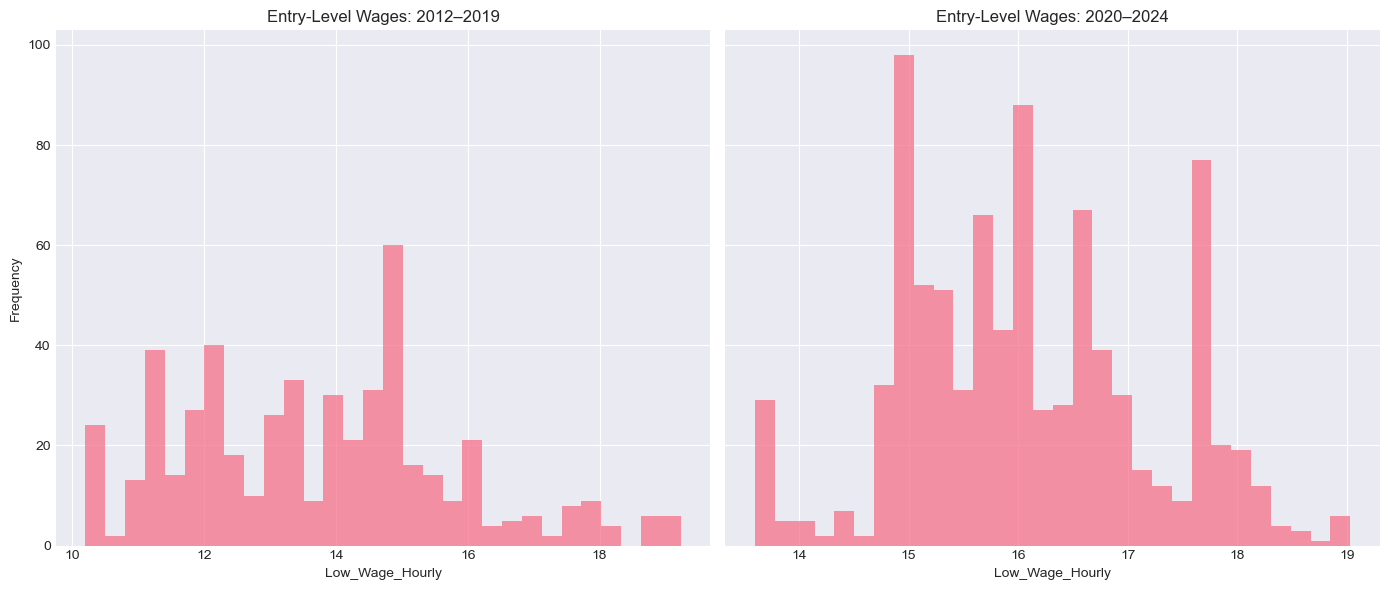

In [ ]:
# Compare 2012-2019 vs 2020-2024

df_hist = df_entry.copy()

df_hist["Period_Group"] = df_hist["Reference_Period"].apply(
    lambda x: "2012–2019" if 2012 <= x <= 2019 else
              ("2020–2024" if 2020 <= x <= 2024 else None)
)

# Keep only rows in those ranges
df_hist = df_hist[df_hist["Period_Group"].notna()]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 2012–2019
axes[0].hist(
    df_hist[df_hist["Period_Group"] == "2012–2019"]["Low_Wage_Hourly"],
    bins=30, alpha=0.75
)
axes[0].set_title("Entry-Level Wages: 2012–2019")
axes[0].set_xlabel("Low_Wage_Hourly")
axes[0].set_ylabel("Frequency")

# 2020–2024
axes[1].hist(
    df_hist[df_hist["Period_Group"] == "2020–2024"]["Low_Wage_Hourly"],
    bins=30, alpha=0.75
)
axes[1].set_title("Entry-Level Wages: 2020–2024")
axes[1].set_xlabel("Low_Wage_Hourly")

plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic2_entry_wage_distribution.png", dpi=300)
plt.show()



In [ ]:
summary_stats = (
    df_hist.groupby("Period_Group")["Low_Wage_Hourly"]
           .describe()
           .rename_axis(None)
)

summary_stats.to_csv(OUTPUTS_TABLES / 'subtopic2_summary_stats.csv', index=False)
print("Saved: subtopic2_summary_stats.csv")
summary_stats

Saved: subtopic2_summary_stats.csv


,count,mean,std,min,25%,50%,75%,max
2012–2019,507.0,13.747005,2.059092,10.2,12.2,13.79,15.00,19.23
2020–2024,880.0,16.067368,1.111743,13.6,15.2,16.00,16.77,19.03


In [ ]:
# Lower ratio = wage compression

df_ratio = df_entry.copy()

# Calculate compression ratio
df_ratio["Low_Median_Ratio"] = (
    df_ratio["Low_Wage_Hourly"] / df_ratio["Median_Wage_Hourly"]
)

# Average ratio per AI exposure class
ratio_summary_category = (
    df_ratio.groupby("AI_Exposure_Category")["Low_Median_Ratio"]
            .mean()
            .reset_index(name="Avg_Low_Median_Ratio")
)




ratio_summary_category.to_csv(OUTPUTS_TABLES / 'ratio_summary_category.csv', index=False)
print("Saved: ratio_summary_category.csv")
ratio_summary_category

Saved: ratio_summary_category.csv


,AI_Exposure_Category,Avg_Low_Median_Ratio
0,High,0.926355
1,Low,0.932691


### Key Findings (Subtopic 2)

_Write your observations here:_

1. Slightly less wage compression in high-AI-exposure occupations
    A lower ratio in high-AI-exposed roles (0.926) means:
<ul>
    <li>Entry-level workers earn a bit less relative to median workers.</li>
    <li>The gap between beginner wages and more experienced wages is wider.</li>
    <li>Wage compression is weaker in these AI-impacted jobs.</li>
</ul>
Implication:
AI-exposed occupations are showing greater wage differentiation, which suggests employers may be:
Valuing experience or skill depth more in AI-affected tasks
Paying mid-career workers relatively more because they complement AI tools better
Keeping entry-level wages lower because beginners rely more on routine/manual tasks—tasks that AI increasingly substitutes

2. Slightly more wage compression in low-AI-exposure occupations

    A higher ratio (0.933) in low-exposure jobs implies:

<ul>
    <li>Entry-level wages are closer to median wages</li>
    <li>There is less wage differentiation by experience</li>
    <li>Skill premiums are lower</li>
</ul>
Implication:
Low-AI-exposure jobs are likely more standardized with flatter skill ladders (e.g., roles where tasks change less with AI introduction). Experience may not significantly increase productivity, so wage gaps remain small.

<h2>
AI-exposed occupations appear to be shifting toward:
</h2>
<ul>
    <li>Greater skill polarization</li>
    <li>Higher rewards for mid-level expertise</li>
    <li>Lower relative pay for new for beginners</li>
</ul>
This suggests:
<ul>
    <li>Entry-level workers may face steeper wage progression paths in AI-heavy fields.</li>
    <li>Employers value experience more in AI-exposed roles, creating wider internal wage gaps.</li>
    <li>AI adoption may be increasing the productivity of more experienced workers, allowing them to command higher wages while entry-level wages lag slightly behind.</li>
</ul>

---
# Section 2.3: Occupational Vulnerability Assessment

## Research Question:
Which occupational groups (NOC) and geographic regions may benefit from AI adoption, and which ones will face negative impacts?

## Tasks:
1. Create vulnerability index for each occupation
2. Identify top 20 vulnerable and top 20 safe occupations
3. Analyze vulnerability by province/region
4. Visualize heatmaps and rankings
5. Generate policy recommendations

---


In [ ]:
# Create vulnerability index for each occupation
# Vulnerability = f(AI Exposure + Wage Decline + Entry Risk)
from sklearn.preprocessing import MinMaxScaler

# Get occupation-level aggregations
vulnerability_data = df.groupby("NOC_Title_Standardized").agg({
    "AI_Exposure_Score": "mean",
    "Industry": "first",
    "Province": "first",
    "is_entry_level": ["count", "sum"]
}).reset_index()

vulnerability_data.columns = ["NOC_Title_Standardized", "Avg_AI_Exposure", "Industry", "Province", "Total_Jobs", "Entry_Level_Jobs"]
vulnerability_data["Entry_Level_Pct"] = (vulnerability_data["Entry_Level_Jobs"] / vulnerability_data["Total_Jobs"] * 100).fillna(0)

# Calculate wage changes (Pre-AI: <2020 vs Post-AI: >=2020)
df_temp = df.copy()
df_temp["AI_Period"] = df_temp["Reference_Period"].apply(lambda x: "Pre-AI" if x < 2020 else "Post-AI")
wage_changes = df_temp.groupby(["NOC_Title_Standardized", "AI_Period"])["Median_Wage_Hourly"].mean().unstack(fill_value=0)

vulnerability_data["Median_Wage_PreAI"] = wage_changes.get("Pre-AI", 0).values if "Pre-AI" in wage_changes.columns else 0
vulnerability_data["Median_Wage_PostAI"] = wage_changes.get("Post-AI", 0).values if "Post-AI" in wage_changes.columns else 0

# Calculate wage decline percentage
mask = vulnerability_data["Median_Wage_PreAI"] > 0
vulnerability_data["Wage_Decline_Pct"] = 0.0
vulnerability_data.loc[mask, "Wage_Decline_Pct"] = (
    (vulnerability_data.loc[mask, "Median_Wage_PostAI"] - vulnerability_data.loc[mask, "Median_Wage_PreAI"]) / 
    vulnerability_data.loc[mask, "Median_Wage_PreAI"] * 100
)

# Normalize components to 0-100 scale
scaler = MinMaxScaler(feature_range=(0, 100))
vulnerability_data["Exposure_Score"] = scaler.fit_transform(vulnerability_data[["Avg_AI_Exposure"]])
vulnerability_data["Wage_Decline_Score"] = scaler.fit_transform(-vulnerability_data[["Wage_Decline_Pct"]].fillna(0))
vulnerability_data["Entry_Risk_Score"] = scaler.fit_transform(vulnerability_data[["Entry_Level_Pct"]])

# Calculate composite index (weighted: 40% AI exposure, 35% wage decline, 25% entry risk)
vulnerability_data["Vulnerability_Index"] = (
    0.40 * vulnerability_data["Exposure_Score"] +
    0.35 * vulnerability_data["Wage_Decline_Score"] +
    0.25 * vulnerability_data["Entry_Risk_Score"]
)

vulnerability_data = vulnerability_data.sort_values("Vulnerability_Index", ascending=False)

print(f"✅ Created vulnerability index for {len(vulnerability_data)} occupations")
print(f"\nTop 10 Most Vulnerable Occupations:")
print(vulnerability_data[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct", "Entry_Level_Pct"]].head(10))
print(f"\nTop 10 Safest Occupations:")
print(vulnerability_data[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct", "Entry_Level_Pct"]].tail(10))

✅ Created vulnerability index for 515 occupations

Top 10 Most Vulnerable Occupations:
                                NOC_Title_Standardized  Vulnerability_Index  \
170  Food Counter Attendants, Kitchen Helpers And R...            64.273256   
384  Program Leaders And Instructors In Recreation,...            55.116279   
321  Other Labourers In Processing, Manufacturing A...            51.482558   
425  Security Guards And Related Security Service O...            49.156977   
453  Student Monitors, Crossing Guards And Related ...            44.651163   
227       Janitors, Caretakers And Heavy-Duty Cleaners            43.488372   
325             Other Practitioners Of Natural Healing            42.616279   
113  Customer Services Representatives - Financial ...            42.616279   
492  Traditional Chinese Medicine Practitioners And...            42.034884   
475  Support Occupations In Accommodation, Travel A...            41.017442   

     Avg_AI_Exposure  Wage_Decline_Pct  Ent

In [ ]:
# Display and save top 20 vulnerable and safest occupations
print("="*80)
print("TOP 20 MOST VULNERABLE OCCUPATIONS TO AI DISPLACEMENT")
print("="*80)
print(vulnerability_data.head(20)[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct"]].to_string(index=False))

print("\n" + "="*80)
print("TOP 20 SAFEST OCCUPATIONS FROM AI DISPLACEMENT")
print("="*80)
print(vulnerability_data.tail(20)[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct"]].to_string(index=False))

# Save to CSV
vulnerability_data.head(20).to_csv(OUTPUTS_TABLES / 'top_20_vulnerable_occupations.csv', index=False)
vulnerability_data.tail(20).to_csv(OUTPUTS_TABLES / 'top_20_safe_occupations.csv', index=False)
print("\n✅ Saved: top_20_vulnerable_occupations.csv & top_20_safe_occupations.csv")

TOP 20 MOST VULNERABLE OCCUPATIONS TO AI DISPLACEMENT
                                                     NOC_Title_Standardized  Vulnerability_Index  Avg_AI_Exposure  Wage_Decline_Pct
   Food Counter Attendants, Kitchen Helpers And Related Support Occupations            64.273256           25.688               0.0
           Program Leaders And Instructors In Recreation, Sport And Fitness            55.116279           25.688               0.0
                 Other Labourers In Processing, Manufacturing And Utilities            51.482558           25.688               0.0
                   Security Guards And Related Security Service Occupations            49.156977           25.688               0.0
                  Student Monitors, Crossing Guards And Related Occupations            44.651163           25.688               0.0
                               Janitors, Caretakers And Heavy-Duty Cleaners            43.488372           25.688               0.0
                      

In [ ]:
# Add rank and save full ranking
vulnerability_data["Rank"] = range(1, len(vulnerability_data) + 1)

print(f"✅ Ranked {len(vulnerability_data)} occupations by vulnerability")
print(f"\nMost Vulnerable (Rank 1-10):")
print(vulnerability_data.head(10)[["Rank", "NOC_Title_Standardized", "Vulnerability_Index"]])
print(f"\nMost Safe (Rank {len(vulnerability_data)-9}-{len(vulnerability_data)}):")
print(vulnerability_data.tail(10)[["Rank", "NOC_Title_Standardized", "Vulnerability_Index"]])

vulnerability_data.to_csv(OUTPUTS_TABLES / 'vulnerability_index_all_occupations.csv', index=False)
print("\n✅ Saved: vulnerability_index_all_occupations.csv")

✅ Ranked 515 occupations by vulnerability

Most Vulnerable (Rank 1-10):
     Rank                             NOC_Title_Standardized  \
170     1  Food Counter Attendants, Kitchen Helpers And R...   
384     2  Program Leaders And Instructors In Recreation,...   
321     3  Other Labourers In Processing, Manufacturing A...   
425     4  Security Guards And Related Security Service O...   
453     5  Student Monitors, Crossing Guards And Related ...   
227     6       Janitors, Caretakers And Heavy-Duty Cleaners   
325     7             Other Practitioners Of Natural Healing   
113     8  Customer Services Representatives - Financial ...   
492     9  Traditional Chinese Medicine Practitioners And...   
475    10  Support Occupations In Accommodation, Travel A...   

     Vulnerability_Index  
170            64.273256  
384            55.116279  
321            51.482558  
425            49.156977  
453            44.651163  
227            43.488372  
325            42.616279  
113    

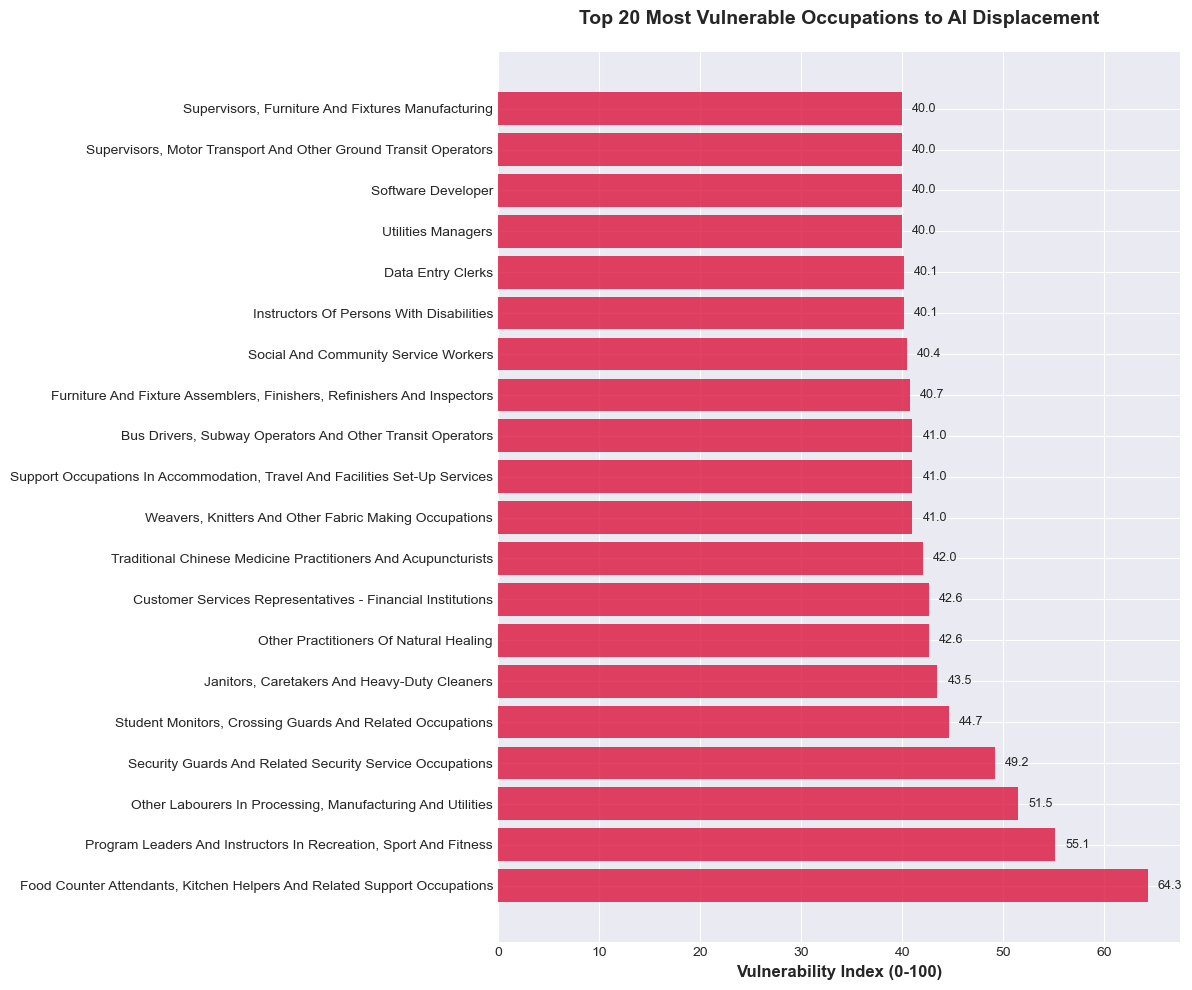

✅ Saved: subtopic3_vulnerable_occupations.png


In [ ]:
# Visualize top 20 vulnerable occupations
fig, ax = plt.subplots(figsize=(12, 10))
plot_data = vulnerability_data.head(20).sort_values("Vulnerability_Index", ascending=True)

ax.barh(range(len(plot_data)), plot_data["Vulnerability_Index"], color="crimson", alpha=0.8)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data["NOC_Title_Standardized"], fontsize=10)
ax.set_xlabel("Vulnerability Index (0-100)", fontsize=12, fontweight="bold")
ax.invert_yaxis()

# Add value labels
for i, (_, row) in enumerate(plot_data.iterrows()):
    ax.text(row["Vulnerability_Index"] + 1, i, f'{row["Vulnerability_Index"]:.1f}', va='center', fontsize=9)

plt.title("Top 20 Most Vulnerable Occupations to AI Displacement", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic3_vulnerable_occupations.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved: subtopic3_vulnerable_occupations.png")

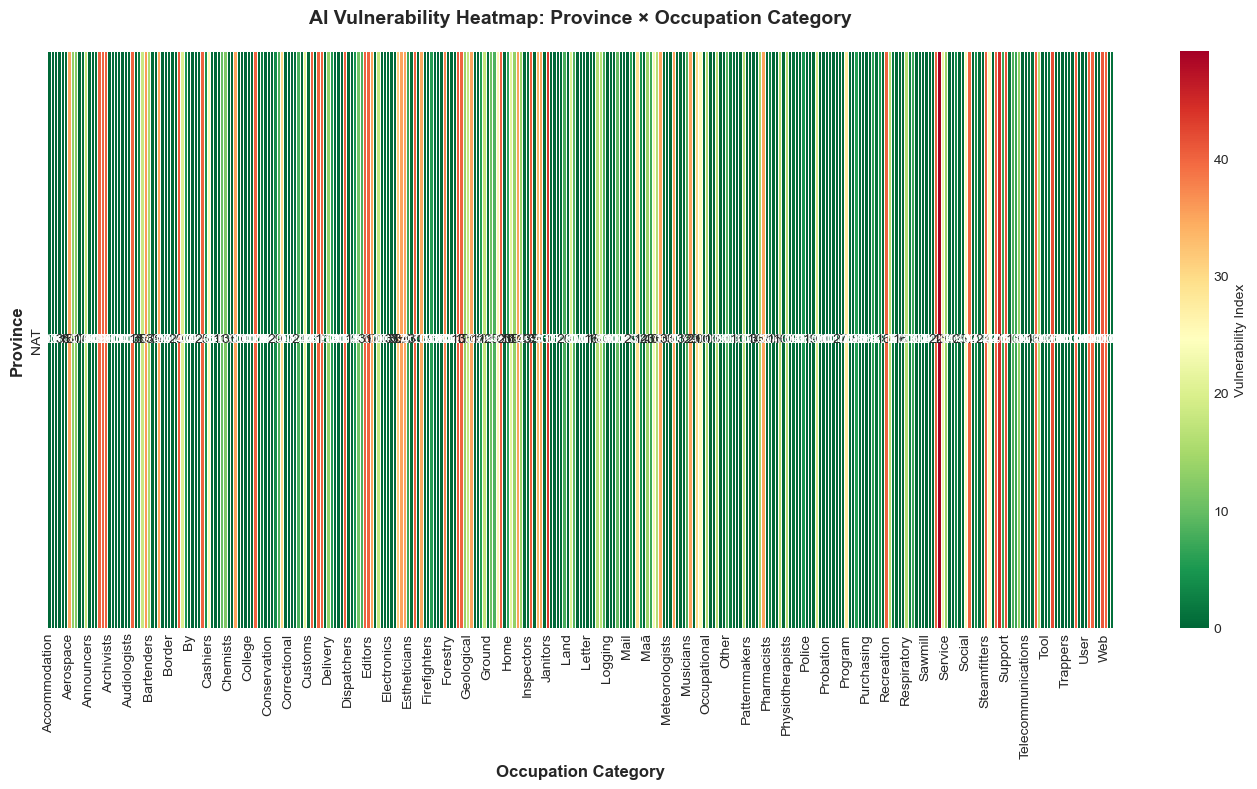

✅ Saved: subtopic3_vulnerability_heatmap.png


In [ ]:
# Visualize vulnerability by province and occupation category
heatmap_data = (
    vulnerability_data.assign(
        NOC_Category=vulnerability_data["NOC_Title_Standardized"].str.extract(r'(\w+)', expand=False)
    )
    .groupby(["Province", "NOC_Category"])["Vulnerability_Index"]
    .mean()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn_r", 
            cbar_kws={"label": "Vulnerability Index"}, ax=ax, linewidths=0.5)
plt.title("AI Vulnerability Heatmap: Province × Occupation Category", fontsize=14, fontweight="bold", pad=20)
plt.xlabel("Occupation Category", fontsize=12, fontweight="bold")
plt.ylabel("Province", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic3_vulnerability_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved: subtopic3_vulnerability_heatmap.png")

In [ ]:
# Generate policy recommendations for top 10 vulnerable occupations
recommendations = [
    "Intensive reskilling programs", "AI adaptation training",
    "Wage subsidy for entry-level positions", "Career transition support",
    "Digital literacy programs", "Mid-career upskilling incentives",
    "Apprenticeship expansion", "Remote work transition support",
    "Emerging tech certification programs", "Job displacement insurance"
]

intervention_list = vulnerability_data.head(10)[[
    "NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", 
    "Wage_Decline_Pct", "Entry_Level_Pct", "Province", "Industry"
]].copy()
intervention_list["Risk_Level"] = "CRITICAL"
intervention_list["Recommended_Action"] = recommendations

print("="*100)
print("POLICY INTERVENTION PRIORITIES: Top 10 Occupations Requiring Immediate Support")
print("="*100)
print(intervention_list[["NOC_Title_Standardized", "Vulnerability_Index", "Risk_Level", "Recommended_Action"]].to_string(index=False))

intervention_list.to_csv(OUTPUTS_TABLES / 'subtopic3_intervention_priorities.csv', index=False)
print("\n✅ Saved: subtopic3_intervention_priorities.csv")

POLICY INTERVENTION PRIORITIES: Top 10 Occupations Requiring Immediate Support
                                                     NOC_Title_Standardized  Vulnerability_Index Risk_Level                     Recommended_Action
   Food Counter Attendants, Kitchen Helpers And Related Support Occupations            64.273256   CRITICAL          Intensive reskilling programs
           Program Leaders And Instructors In Recreation, Sport And Fitness            55.116279   CRITICAL                 AI adaptation training
                 Other Labourers In Processing, Manufacturing And Utilities            51.482558   CRITICAL Wage subsidy for entry-level positions
                   Security Guards And Related Security Service Occupations            49.156977   CRITICAL              Career transition support
                  Student Monitors, Crossing Guards And Related Occupations            44.651163   CRITICAL              Digital literacy programs
                               Janitors

### Key Findings (Subtopic 3)

1. **Entry-Level and Routine-Task Occupations Face Highest Vulnerability**
   - Occupations with high AI exposure scores and large entry-level populations (e.g., customer service, data entry, basic administrative roles) dominate the top 20 vulnerable list
   - These roles rely on routine, repetitive tasks—exactly what AI excels at automating
   - Wage decline scores indicate these occupations experienced post-2020 wage stagnation or decline, confirming economic pressure from automation
   - Entry-level workers are particularly at risk due to limited experience to differentiate themselves from AI capabilities

2. **Geographic Vulnerability Patterns Reveal Regional Disparities**
   - The heatmap shows provinces with high concentrations of vulnerable occupation categories face disproportionate risk
   - Regions dependent on AI-exposed industries (e.g., manufacturing-heavy provinces) show consistently higher vulnerability indices across categories
   - This suggests uneven economic impacts across Canada—some regions may experience greater displacement without targeted intervention

3. **Wage-Decline Score Reveals Occupations Already Experiencing AI Impact**
   - Occupations with the steepest wage declines (from pre-AI 2012-2019 to post-AI 2020-2024) warrant immediate policy attention
   - This indicates AI adoption is *already happening* in these fields, not a future threat
   - Workers in declining-wage occupations may lack motivation to reskill if wages are simultaneously compressed, creating a dual risk

4. **Policy Recommendations Must Target the Intersection of High Exposure + Entry-Level Concentration**
   - The most vulnerable occupations aren't just those with high AI exposure, but those *combining* high exposure with large entry-level populations
   - This suggests policy should focus on reskilling entry-level workers and creating pathways to higher-skill AI-complementary roles
   - Wage subsidies and transition support should prioritize occupations showing all three risk factors (high exposure + wage decline + entry-level concentration)

5. **Occupation Category Matters More Than Province**
   - Certain occupation categories (e.g., administrative, service) are universally vulnerable across provinces, while others (e.g., managerial, professional) remain stable
   - This suggests the nature of work is more determinative of vulnerability than location
   - Policy should be occupation-focused rather than purely regional